In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch as th
import matplotlib.pyplot as plt
from aimanager.utils.utils import make_dir
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})


run = '02_recorded'

data_folder = f'../../data/human_like_manager/{run}'
plot_folder = f'plots/{run}'

make_dir(plot_folder)

/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def _plot_heatmap(data, x, y, values, normalise=True):
    dfg = data.groupby([x,y])[values].sum()
    dfg = dfg.reset_index()
    if normalise:
        dfg[values] = dfg[values] / dfg.groupby([x])[values].transform('sum')
    cm = dfg.pivot_table(index=x, columns=y, values=values)
    cm = cm.sort_index(ascending=False)
    sns.heatmap(cm)

def merge_data(data_folder, metric_name):
    folder = os.path.join(data_folder, metric_name)
    dfs = [pd.read_parquet(os.path.join(folder, file)) for file in os.listdir(folder)]
    df = pd.concat(dfs).reset_index(drop=True)
    return df


In [3]:
metrics_df = merge_data(data_folder, 'metrics')
confusion_matrix_df = merge_data(data_folder, 'confusion_matrix')
metrics_df['shuffle_feature'] = metrics_df['shuffle_feature'].fillna('none')
labels = list(set(metrics_df.columns) - set(['job_id', 'name', 'value', 'cv_split', 'epoch', 'set', 'strategy', 'shuffle_feature']))
labels

['mask_name']

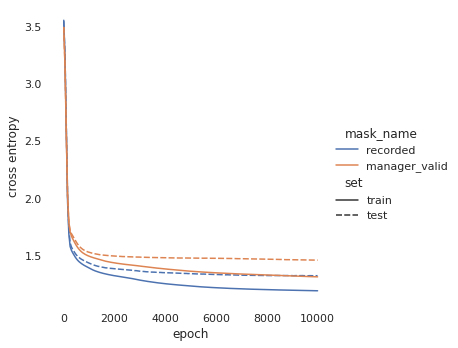

In [5]:
df = metrics_df.copy()


selection = {
    'name': 'log_loss',
    'shuffle_feature': 'none',
    # 'set': 'test'
}

focus = ['mask_name', 'set']

w = pd.concat(
    (df[k].isin(v) if isinstance(v, list) else df[k] == v
    for k,v in selection.items()
    if (k not in focus) or isinstance(v, list)), axis=1
).all(1)

df = df[w]

fg = sns.relplot(
    data=df, 
    x='epoch', y='value',
    hue=focus[0] if len(focus) >= 1 else None, 
    style=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='line', ci=None)

fg.set(ylabel='cross entropy')

fg.savefig(os.path.join(plot_folder, 'learning_curve_model.jpg'))

In [6]:
import statsmodels.formula.api as smf


df = metrics_df.copy()

w = (
    (df['name'] == 'log_loss') &
    (df['set'] == 'test') &
    (df['shuffle_feature'] == 'none')
)
df = df[w].copy()
w_max = (df['epoch'] > (0.8 * df['epoch'].max()))
df = df[w_max].copy()

In [7]:
dfg = df.groupby(labels)['value'].mean().reset_index()
dfg = dfg.sort_values('value')
dfg = dfg.rename(columns={'value': 'log loss'})
dfg

,mask_name,log loss
1,recorded,1.328176
0,manager_valid,1.466848


/tmp/ipykernel_37535/2388140929.py:19: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df = pd.concat([dfc, df]).reset_index()


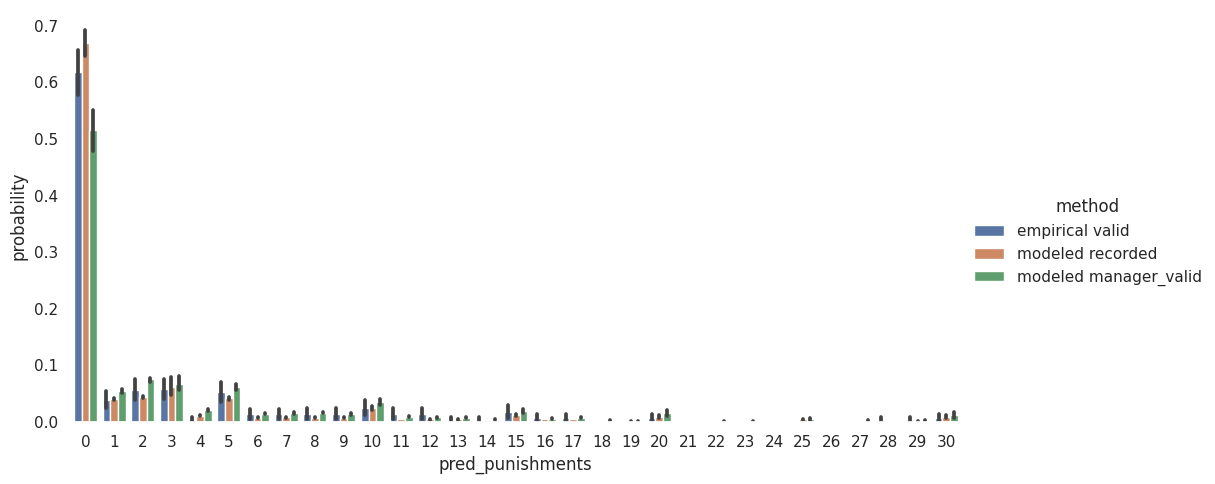

In [13]:
df = confusion_matrix_df.copy()

w = (
    (df['round_number'] == 0) &
    (df['valid']) &
    (df['set'] == 'test')
)

df = df[w]

dfc = df.copy()

dfc['probability'] = dfc['pred_punishments'] == dfc['true_punishments']
dfc['method'] = 'empirical valid'

df['probability'] = df['proba']
df['method'] = 'modeled ' + df['mask_name']

df = pd.concat([dfc, df]).reset_index()

fg = sns.catplot(
    data=df, x='pred_punishments', y='probability',
    hue='method',
    height=5, kind='bar', aspect=2)

/tmp/ipykernel_37535/192169571.py:18: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df = pd.concat([dfc, df]).reset_index()


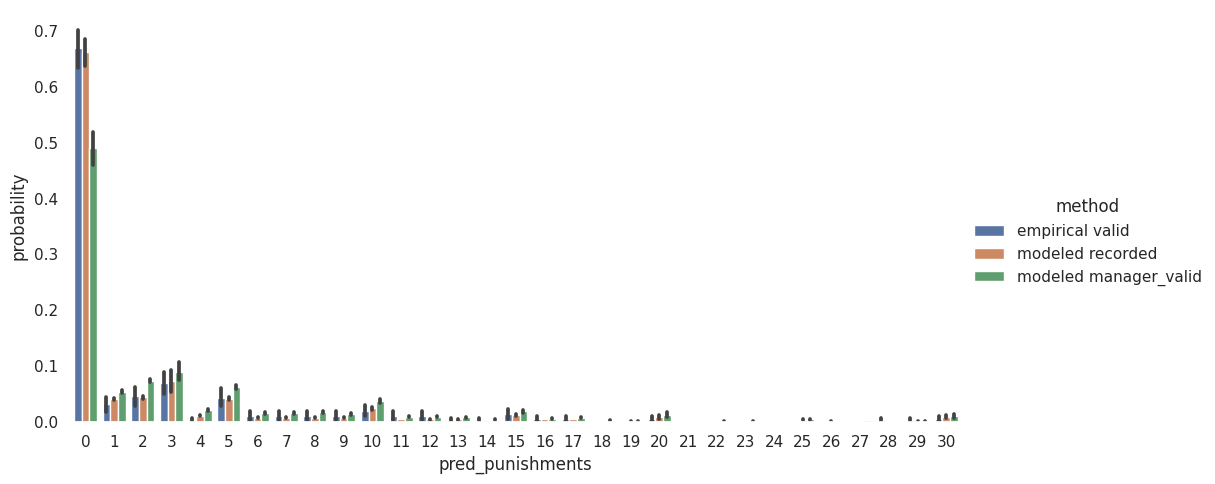

In [18]:
df = confusion_matrix_df.copy()

w = (
    (df['round_number'] == 0) &
    (df['set'] == 'test')
)

df = df[w]

dfc = df.copy()

dfc['probability'] = dfc['pred_punishments'] == dfc['true_punishments']
dfc['method'] = 'empirical valid'

df['probability'] = df['proba']
df['method'] = 'modeled ' + df['mask_name']

df = pd.concat([dfc, df]).reset_index()

df['exp'] = df['pred_punishments'] * df['probability']

fg = sns.catplot(
    data=df, x='pred_punishments', y='probability',
    hue='method',
    height=5, kind='bar', aspect=2)

/tmp/ipykernel_37535/1881246167.py:17: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df = pd.concat([dfc, df]).reset_index()


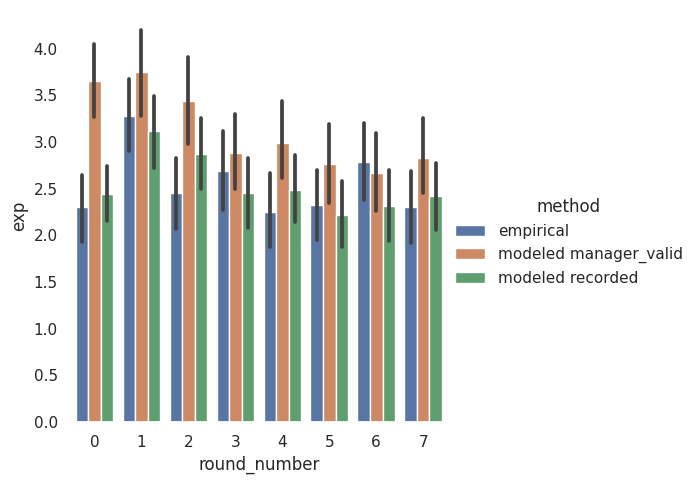

In [26]:
df = confusion_matrix_df.copy()

w = (
    (df['set'] == 'test')
)

df = df[w]

dfc = df.copy()

dfc['probability'] = dfc['pred_punishments'] == dfc['true_punishments']
dfc['method'] = 'empirical'

df['probability'] = df['proba']
df['method'] = 'modeled ' + df['mask_name']

df = pd.concat([dfc, df]).reset_index()

df['exp'] = df['pred_punishments'] * df['probability']

dfg = df.groupby(['mask_name', 'job_id', 'set', 'cv_split', 'epoch', 'idx',
       'round_number', 'method'])['exp'].sum().reset_index()

fg = sns.catplot(
    data=dfg, hue='method', y='exp', x='round_number', height=5, kind='bar')

In [25]:
df

,index,mask_name,job_id,set,cv_split,epoch,idx,round_number,pred_punishments,proba,valid,true_punishments,probability,method,exp
0,71424,recorded,mask_name_recorded,test,0,9999,0,0,0,9.150260e-01,True,0,1.000000e+00,empirical,0.000000e+00
1,71425,recorded,mask_name_recorded,test,0,9999,0,0,1,1.691819e-02,True,0,0.000000e+00,empirical,0.000000e+00
2,71426,recorded,mask_name_recorded,test,0,9999,0,0,2,1.533143e-02,True,0,0.000000e+00,empirical,0.000000e+00
3,71427,recorded,mask_name_recorded,test,0,9999,0,0,3,8.548629e-03,True,0,0.000000e+00,empirical,0.000000e+00
4,71428,recorded,mask_name_recorded,test,0,9999,0,0,4,5.007831e-03,True,0,0.000000e+00,empirical,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345211,1035643,manager_valid,mask_name_manager_valid,test,5,9999,55,7,26,3.649814e-05,True,10,3.649814e-05,modeled manager_valid,9.489517e-04
345212,1035644,manager_valid,mask_name_manager_valid,test,5,9999,55,7,27,3.864469e-04,True,10,3.864469e-04,modeled manager_valid,1.043407e-02
345213,1035645,manager_valid,mask_name_manager_valid,test,5,9999,55,7,28,4.680973e-04,True,10,4.680973e-04,modeled manager_valid,1.310673e-02
345214,1035646,manager_valid,mask_name_manager_valid,test,5,9999,55,7,29,3.779180e-09,True,10,3.779180e-09,modeled manager_valid,1.095962e-07


In [ ]:
# TODO: heatmap